# Dog Breed Classification Notebook

## Imported Libraries

In [ ]:
!pip install efficientnet pyyaml h5py  
!pip install -q -U keras-tuner
!pip install tensorflow_addons

import os
import math
import pandas as pd
from scipy.io import loadmat
from random import randrange
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

import efficientnet.tfkeras as efn

import kerastuner as kt

%matplotlib inline

#change path to Google Drive path that you are running the notebook from
path = '/content/drive/MyDrive/CZ4041 Assignment/'

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 706kB 6.4MB/s 


#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Set Up TPU for TPU enabled training 

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.57.60.154:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.57.60.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.57.60.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Read, Augment and Normalize TFRecords from the Google Storage Bucket

In [ ]:
def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "breed": tf.io.FixedLenFeature([], tf.int64),
      "breed_oh": tf.io.VarLenFeature(tf.float32)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])
  
  breed_oh = tf.sparse.to_dense(feature['breed_oh'])
  breed_oh = tf.reshape(breed_oh, [120])

  return image, breed_oh

def augment(image, labels):
  # image = tf.image.random_crop(image, size=[BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 3]) # Random crop back
  # image = tf.image.random_brightness(image, max_delta=0.2) # Random brightness
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_contrast(image, 0.8, 1.2)
  # # image = tf.image.random_jpeg_quality(image, 10, 80)
  # image = tf.image.random_saturation(image, lower=0.75, upper=1.2)
  # # image = tf.image.random_hue(image, 0.2)
  image = tf.image.random_crop(image, size=[BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 3]) # Random crop back
  image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.9, 1.1)

  return image, labels

def normalise(image, labels):
  # image = tf.cast(image, tf.float32) * (1. / 255)
  image = tf.cast(image, tf.float32) 

  return image, labels

### authenticate Google credentials

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Declare and Prepare Training and Validation Dataset from Google Cloud Storage

In [ ]:
IMAGE_SIZE = [331,331]  # image size to input to model
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
# tfrecord_train_dir = 'gs://cz4041_train'  # google cloud storage training data file path
# tfrecord_val_dir = 'gs://cz4041_val' # google cloud storage validation data file path

# tfrecord_train_dir = 'gs://cz4041_train_org'  # google cloud storage training data file path
# tfrecord_val_dir = 'gs://cz4041_val_org' # google cloud storage validation data file path

tfrecord_train_dir = 'gs://cz4041_train_10'  # google cloud storage training data file path
tfrecord_val_dir = 'gs://cz4041_val_10' # google cloud storage validation data file path

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

train_path = tf.io.gfile.glob(tfrecord_train_dir + "/*.tfrec")
val_path = tf.io.gfile.glob(tfrecord_val_dir + "/*.tfrec")

training_dataset = tf.data.TFRecordDataset(train_path, num_parallel_reads=AUTO)
training_dataset = training_dataset.with_options(option_no_order)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.shuffle(1000 + 3*BATCH_SIZE)
training_dataset = training_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
training_dataset = training_dataset.batch(BATCH_SIZE)
training_dataset = training_dataset.map(augment, num_parallel_calls=AUTO)
training_dataset = training_dataset.map(normalise, num_parallel_calls=AUTO)
training_dataset = training_dataset.prefetch(AUTO)

val_dataset = tf.data.TFRecordDataset(val_path, num_parallel_reads=AUTO)
val_dataset = val_dataset.with_options(option_no_order)
val_dataset = val_dataset.map(read_tfrecord, num_parallel_calls=AUTO)
val_dataset = val_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.map(augment, num_parallel_calls=AUTO)
val_dataset = val_dataset.map(normalise, num_parallel_calls=AUTO)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(AUTO)

training_dataset2 = tf.data.TFRecordDataset(train_path)
training_dataset2 = training_dataset2.map(read_tfrecord)
training_dataset2 = training_dataset2.map(normalise)
training_dataset2 = training_dataset2.batch(BATCH_SIZE)

val_dataset2 = tf.data.TFRecordDataset(val_path)
val_dataset2 = val_dataset2.map(read_tfrecord)
val_dataset2 = val_dataset2.map(normalise)
val_dataset2 = val_dataset2.batch(BATCH_SIZE)

In [ ]:
count = 0
num_of_images = 0
for step, element in enumerate(training_dataset2.as_numpy_iterator()):
  if count == 0:
    print("Step number: " + str(step))
    print("Number of images in first step of training dataset: " + str(element[0].shape[0]))

  count += 1
  num_of_images += element[0].shape[0]

val_count = 0
val_num_of_images = 0
for step, element in enumerate(val_dataset2.as_numpy_iterator()):
  if val_count == 0:
    print("Step number: " + str(step))
    print("Number of images in first step of training dataset: " + str(element[0].shape[0]))

  val_count += 1
  val_num_of_images += element[0].shape[0]

Step number: 0
Number of images in first step of training dataset: 64
Step number: 0
Number of images in first step of training dataset: 64


In [ ]:
print("Number of TFRecords for Training Dataset: " + str(count))
print("Number of total Training images: " + str(num_of_images))
print("Number of TFRecords for Validation Dataset: " + str(val_count))
print("Number of total Validation images: " + str(val_num_of_images))
print("Number of total images: " + str(val_num_of_images+num_of_images))

## This shows that the number of images are the same as the Training dataset from Kaggle

Number of TFRecords for Training Dataset: 144
Number of total Training images: 9199
Number of TFRecords for Validation Dataset: 16
Number of total Validation images: 1023
Number of total images: 10222


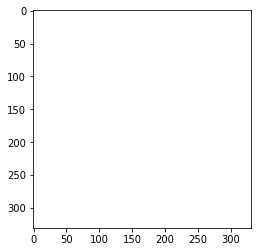

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image

for image, labels in training_dataset.unbatch().take(1):
  plt.imshow(image)
  # print(image)

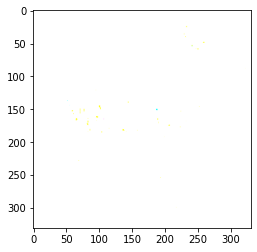

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image

for image, labels in val_dataset.unbatch().take(1):
  plt.imshow(image)
  # print(image)
  

In [ ]:
# df = pd.read_csv(path + 'labels.csv')
# ensure that you have the labels.csv file added to the "Files" section on the left

df = pd.read_csv('/content/labels.csv')
df.columns = ['filename', 'label']

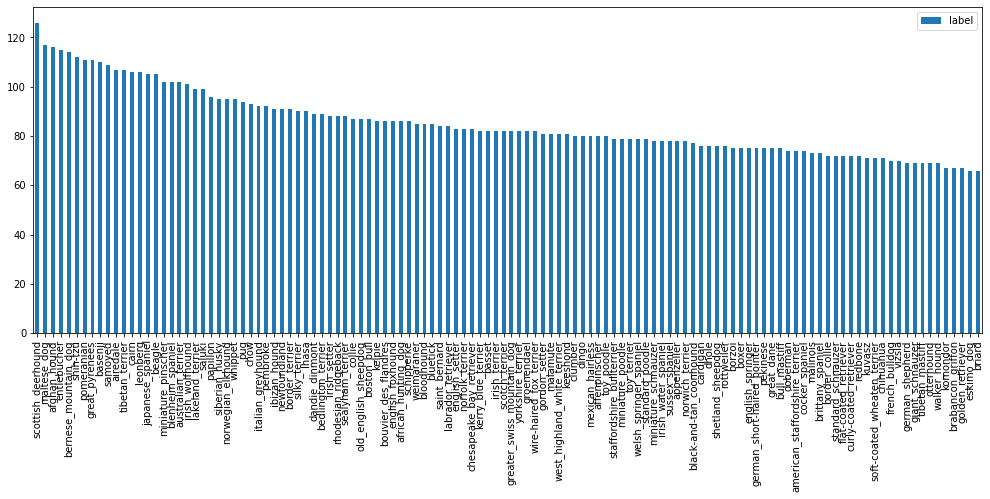

In [ ]:
x = pd.DataFrame(df['label'].value_counts())
x.astype('int64').dtypes
ax = x.plot.bar(figsize=(17,6),y='label', rot=90)

In [ ]:
# df2 = pd.read_csv('/content/drive/MyDrive/CZ4041 Assignment/new_labels/new_labels.csv')
# df2.drop(['Unnamed: 0'], axis='columns', inplace=True)
# df2.columns = ['filename', 'label']

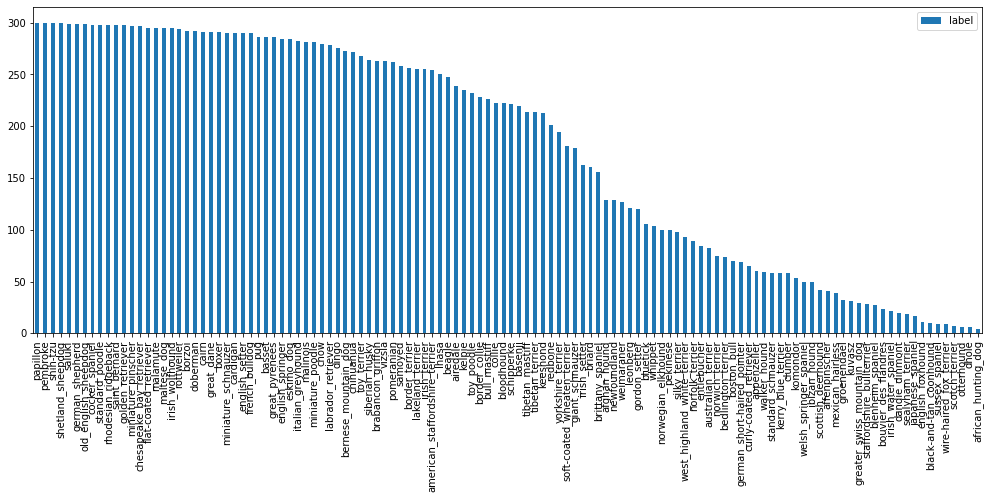

In [ ]:
# x = pd.DataFrame(df2['label'].value_counts())
# x.astype('int64').dtypes
# ax = x.plot.bar(figsize=(17,6),y='label', rot=90)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.filename.values, df.label.values, test_size=0.20, random_state=42, stratify=df[['label']])

In [ ]:
# X_train2 = df2.filename.values
# y_train2 = df2.label.values
# y_train = np.concatenate([y_train,y_train2])

## Declare and initialize Class Weights for Training of Deep Learning Model

In [ ]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.0647135416666667, 1: 0.7327060931899642, 2: 0.9875603864734299, 3: 0.8016666666666666, 4: 1.1549435028248587, 5: 1.0990591397849463, 6: 0.8412551440329218, 7: 0.7743371212121212, 8: 1.032449494949495, 9: 0.8112103174603175, 10: 0.9597417840375587, 11: 0.7488095238095238, 12: 1.0990591397849463, 13: 0.8412551440329218, 14: 1.0020833333333334, 15: 1.0020833333333334, 16: 1.1748563218390804, 17: 0.9334474885844749, 18: 1.1356944444444443, 19: 0.973452380952381, 20: 0.9875603864734299, 21: 1.1356944444444443, 22: 1.2618827160493826, 23: 1.285691823899371, 24: 1.1748563218390804, 25: 1.1356944444444443, 26: 0.8016666666666666, 27: 1.1170765027322405, 28: 1.032449494949495, 29: 1.19546783625731, 30: 0.9208333333333333, 31: 1.0647135416666667, 32: 1.1549435028248587, 33: 0.973452380952381, 34: 1.1748563218390804, 35: 0.9597417840375587, 36: 1.1170765027322405, 37: 1.0647135416666667, 38: 1.1549435028248587, 39: 0.9875603864734299, 40: 1.032449494949495, 41: 1.1356944444444443, 42: 0.740

## Learning Rate Scheduler

In [ ]:
LR = 0.0001 # 0.0005
EPOCHS = 40
WARMUP = 10

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR, num_warmup_steps=WARMUP, num_training_steps=EPOCHS)

## Function to build CNN model for Dog Breed Classification (EfficientNetB7 Base Model)

In [ ]:
def build_model(dropout=0):

  base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet',classes=df['label'].nunique())
  base_model2 = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', classes=df['label'].nunique())
  # base_model3 = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet',classes=df['label'].nunique())
  base_model3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',classes=df['label'].nunique())
  base_model4 = tf.keras.applications.NASNetLarge(include_top=False, weights='imagenet',classes=df['label'].nunique())
  base_model5 = tf.keras.applications.Xception(include_top=False, weights='imagenet',classes=df['label'].nunique())

  for layer in base_model.layers:
      layer.trainable = False

  for layer in base_model2.layers:
      layer.trainable = False

  for layer in base_model3.layers:
      layer.trainable = False

  for layer in base_model4.layers:
      layer.trainable = False

  for layer in base_model5.layers:
      layer.trainable = False

  model_input = Input(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1],3])

  x1 = tf.keras.applications.efficientnet.preprocess_input(model_input)
  x1 = base_model(x1)
  x1 = GlobalAveragePooling2D()(x1)
  
  x2 = tf.keras.applications.inception_resnet_v2.preprocess_input(model_input)
  x2 = base_model2(x2)
  x2 = GlobalAveragePooling2D()(x2)
  
  # x3 = tf.keras.applications.densenet.preprocess_input(model_input)
  x3 = tf.keras.applications.inception_v3.preprocess_input(model_input)
  x3 = base_model3(x3)
  x3 = GlobalAveragePooling2D()(x3)
  
  x4 = tf.keras.applications.nasnet.preprocess_input(model_input)
  x4 = base_model4(x4)
  x4 = GlobalAveragePooling2D()(x4)

  x5 = tf.keras.applications.xception.preprocess_input(model_input)
  x5 = base_model5(x5)
  x5 = GlobalAveragePooling2D()(x5)

  x = Concatenate()([x1,x2,x3,x4,x5])
  x = Dropout(dropout)(x)
  x = Dense(df['label'].nunique(), activation='softmax')(x)
  model = Model(inputs=model_input, outputs=x)
  
  # model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-5, momentum=0.9), metrics='accuracy')
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])
  
  return model

## Build and Compile Model

In [ ]:
with strategy.scope():
  model = build_model(0.85)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 331, 331, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv_1 (TFOpLambda)  (None, 331, 331, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv_2 (TFOpLambda)  (None, 331, 331, 3)  0           input_6[0][0]                    
_____________________________

## Train Model for Dog Breed Classification

In [ ]:
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

with strategy.scope():
  # steps_per_epoch= (8177 + 17320) // BATCH_SIZE
  # validation_steps= (2045) // BATCH_SIZE

  # steps_per_epoch= (8177) // BATCH_SIZE
  # validation_steps= (2045) // BATCH_SIZE

  steps_per_epoch= (9199) // BATCH_SIZE
  validation_steps= (1023) // BATCH_SIZE

  ckpt = tf.keras.callbacks.ModelCheckpoint(path + 'checkpoints/ckpt.h5', 
                                              monitor='val_predictions_multi_loss', 
                                              verbose=0, 
                                              save_best_only=True,
                                              save_weights_only=True, 
                                              mode='auto', 
                                              save_freq='epoch')
  
  history = model.fit(
      training_dataset,
      steps_per_epoch=steps_per_epoch,
      validation_data=val_dataset,
      validation_steps=validation_steps,
      epochs=40,
      class_weight=d_class_weights,
      callbacks=[lr_schedule]
  )

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
143/143 [==============================] - 278s 980ms/step - loss: 5.0641 - categorical_accuracy: 0.0061 - val_loss: 4.8182 - val_categorical_accuracy: 0.0042
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-05.
143/143 [==============================] - 51s 359ms/step - loss: 4.9725 - categorical_accuracy: 0.0104 - val_loss: 4.3869 - val_categorical_accuracy: 0.1625
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
143/143 [==============================] - 52s 362ms/step - loss: 4.4281 - categorical_accuracy: 0.0586 - val_loss: 3.5878 - val_categorical_accuracy: 0.8188
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to 3e-05.
143/143 [==============================] - 51s 357ms/step - loss: 3.5471 - categorical_accuracy: 0.3002 - val_loss: 2.5305 - val_categorical_accuracy: 0.9104
Epoch 5/40

Epoch 00005: LearningRateScheduler re

### Save Model Architecture as Image

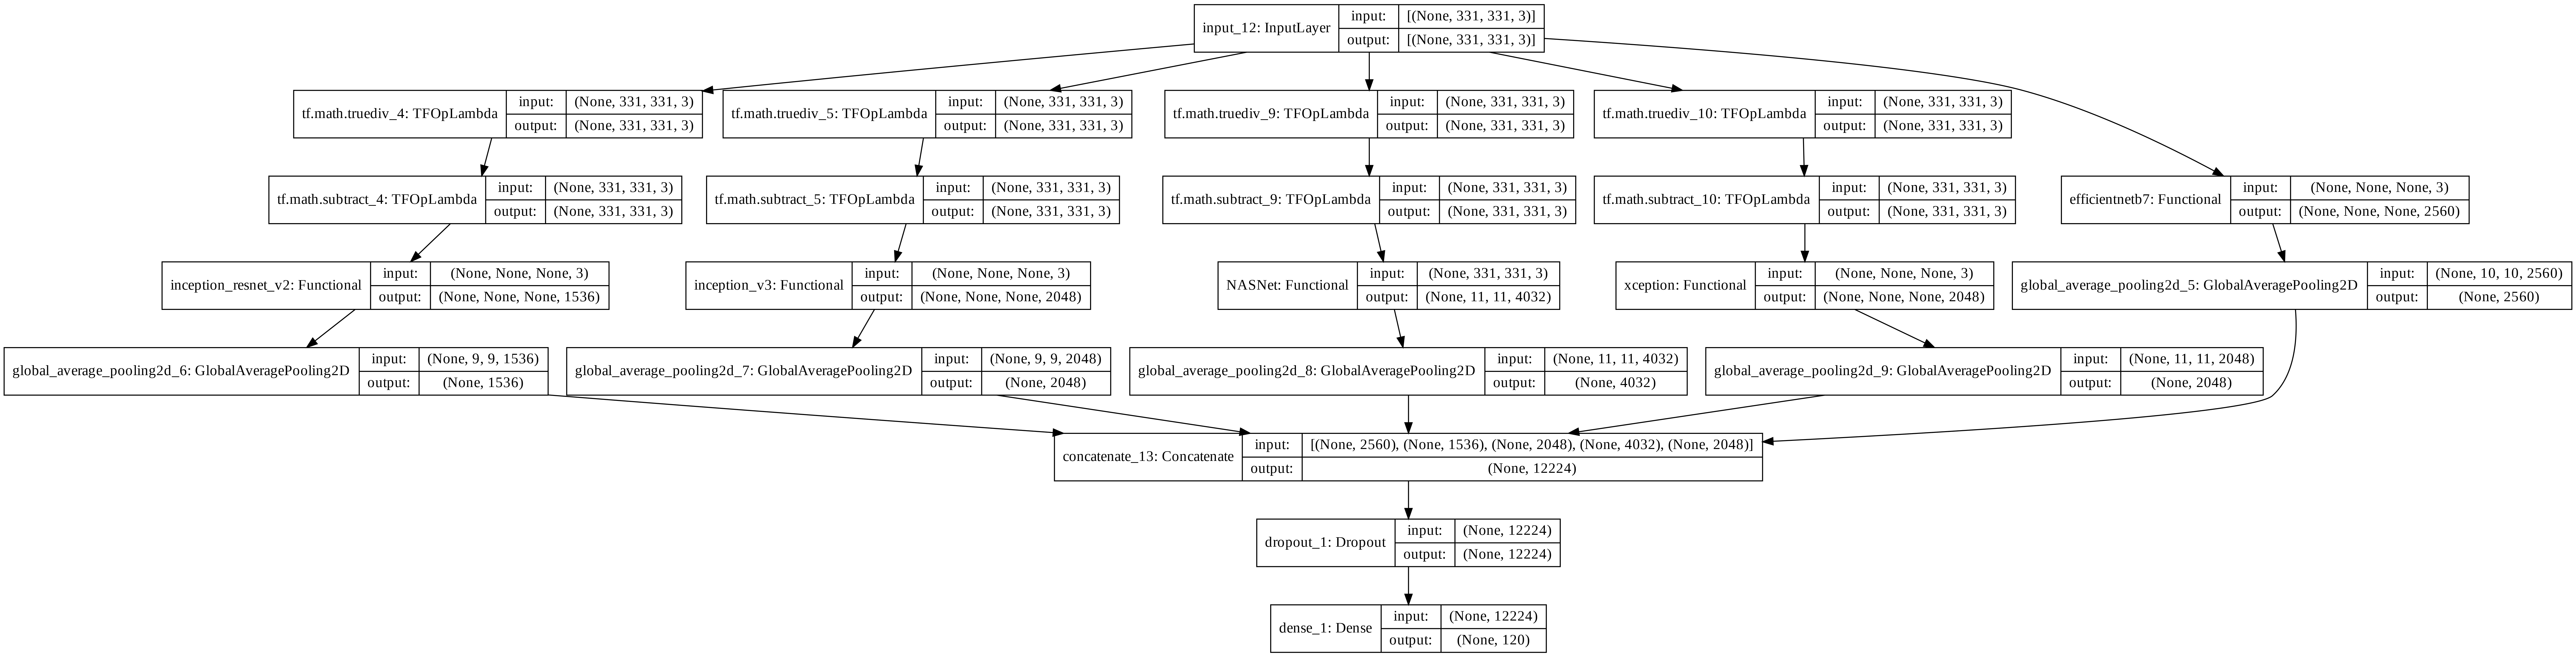

In [ ]:
 # change path to save model architecture to own Google Drive
 #uncomment this cell if you want to save the model architecture as an image

#  tf.keras.utils.plot_model(
#     model,
#     to_file="/content/drive/MyDrive/CZ4041 Assignment/"+"multi_head_concat_model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=300,
# )

### Save trained model

In [ ]:
  # change the path to save the model
  # uncomment this cell to save the trained model

  # model.save('/content/drive/My Drive/CZ4041 Assignment/model_checkpoints/concat_dog_model.h5')

### Model Performance

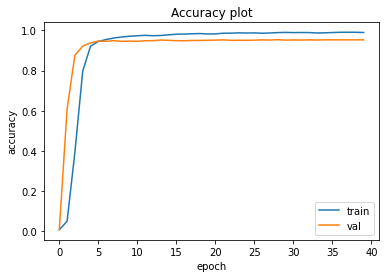

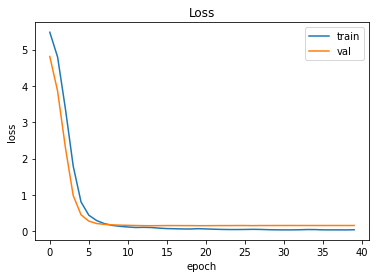

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(20,10))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
# plt.savefig("/content/drive/MyDrive/CZ4041 Assignment/concat_acc.png")
plt.show()

# plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig("/content/drive/MyDrive/CZ4041 Assignment/concat_loss.png")
plt.show()

## Test Model Performance

### Load Test set from Google Storage

In [ ]:
img_names = []

def read_tfrecord(example):
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "image_name": tf.io.FixedLenFeature([], tf.string)
  }

  feature = tf.io.parse_single_example(example, features)

  image = tf.image.decode_jpeg(feature['image'], channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [*IMAGE_SIZE])
  image_name = feature['image_name']
  img_names.append(image_name)
  
  return image, image_name

def normalise(image, labels):
  # image = tf.cast(image, tf.float32) * (1. / 255)
  image = tf.cast(image, tf.float32)

  return image

In [ ]:
IMAGE_SIZE = [331,331]  # image size to input to model
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
tfrecord_test_dir = 'gs://cz4041_test'  # google cloud storage training data file path

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False
AUTO = tf.data.experimental.AUTOTUNE

test_path = tf.io.gfile.glob(tfrecord_test_dir + "/*.tfrec")

test_dataset = tf.data.TFRecordDataset(test_path)
test_dataset = test_dataset.map(read_tfrecord)
test_dataset = test_dataset.map(normalise)
test_dataset = test_dataset.batch(BATCH_SIZE)

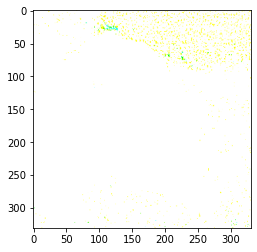

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image

for image in test_dataset.unbatch().take(1):
  plt.imshow(image)
  # print(image)

In [ ]:
#uncomment to load saved model, change the path to the Google Drive fole path where you have saved the model

# with strategy.scope():
#   model = tf.keras.models.load_model('/content/drive/My Drive/CZ4041 Assignment/model_checkpoints/concat_dog_model.h5')

### Predict on Test Set from Kaggle

In [ ]:
print("Predict on test data")
y_pred = model.predict(test_dataset,verbose=1)

Predict on test data
162/162 [==============================] - 158s 433ms/step


In [ ]:
len(y_pred)

10357

### Load class mapping from CSV file

In [ ]:
import csv
# ensure that you have the classes_mapping.csv file added to the "Files" section on the left

with open('/content/classes_mapping.csv', mode='r') as infile:
    reader = csv.DictReader(infile)
    for line in reader: 
        labels = line

In [ ]:
import json

labels = json.loads(json.dumps(labels))

In [ ]:
labels

{'affenpinscher': '0',
 'afghan_hound': '1',
 'african_hunting_dog': '2',
 'airedale': '3',
 'american_staffordshire_terrier': '4',
 'appenzeller': '5',
 'australian_terrier': '6',
 'basenji': '7',
 'basset': '8',
 'beagle': '9',
 'bedlington_terrier': '10',
 'bernese_mountain_dog': '11',
 'black-and-tan_coonhound': '12',
 'blenheim_spaniel': '13',
 'bloodhound': '14',
 'bluetick': '15',
 'border_collie': '16',
 'border_terrier': '17',
 'borzoi': '18',
 'boston_bull': '19',
 'bouvier_des_flandres': '20',
 'boxer': '21',
 'brabancon_griffon': '22',
 'briard': '23',
 'brittany_spaniel': '24',
 'bull_mastiff': '25',
 'cairn': '26',
 'cardigan': '27',
 'chesapeake_bay_retriever': '28',
 'chihuahua': '29',
 'chow': '30',
 'clumber': '31',
 'cocker_spaniel': '32',
 'collie': '33',
 'curly-coated_retriever': '34',
 'dandie_dinmont': '35',
 'dhole': '36',
 'dingo': '37',
 'doberman': '38',
 'english_foxhound': '39',
 'english_setter': '40',
 'english_springer': '41',
 'entlebucher': '42',
 'es

### Load Sample Submission csv

In [ ]:
# ensure that you have the sample_submission.csv file added to the "Files" section on the left

sample_df = pd.read_csv('/content/sample_submission.csv')
sample_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [ ]:
dog_breeds = []
for key in labels.keys():
  dog_breeds.append(key)

In [ ]:
n_classes = len(dog_breeds)
print(n_classes)

120


In [ ]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))

### Save predicitions results to CSV

In [ ]:
#change file path to Google Drive path you want to save the prediction csv file to

for b in dog_breeds:
  # print(b)
  sample_df[b] = y_pred[:,int(labels[b])]
sample_df.to_csv('/content/drive/MyDrive/CZ4041 Assignment/pred.csv', index=None)

In [ ]:
predictions = [np.argmax(y, axis=None, out=None) for y in y_pred]

In [ ]:
predictions[810]

18